In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

SEED = 709
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# NN Implementation for Regression 
Refs: [PyTorch-Example](https://github.com/pytorch/examples/blob/master/regression)

In [2]:
rng = np.random.RandomState(515)
N = 200

X = np.sort(rng.rand(N, 1), axis=0) * 4 * np.pi
y = np.sin(X).ravel() + 0.1 * rng.randn(N)
X_ticks = np.arange(0, 1, 0.01)[:, None] * 4 * np.pi
y_real = np.sin(X_ticks).ravel()

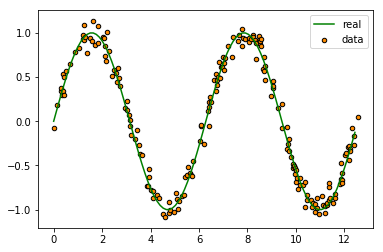

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X.ravel(), y, s=20, c='darkorange', edgecolors='k', label='data')
ax.plot(X_ticks.ravel(), y_real, c='g', label='real')
ax.legend()

In [4]:
from sklearn.preprocessing import StandardScaler
# Standardize input data, only fit on train_set
scaler = StandardScaler()
scaler.fit(X)
print(scaler.mean_, scaler.var_)

X = scaler.transform(X)

[6.82554297] [13.2843321]


In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc_layer1 = nn.Linear(1, 10)
        self.fc_layer2 = nn.Linear(10, 10)
        self.fc_layer3 = nn.Linear(10, 1)
    
    def forward(self, x):
        x = F.relu(self.fc_layer1(x))
        x = F.tanh(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model().to(device)

In [7]:
X = torch.from_numpy(X.astype(np.float32)).to(device)
y = torch.from_numpy(y.astype(np.float32)).to(device)

loss_func = nn.SmoothL1Loss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adadelta(model.parameters())
optimizer = optim.AdamW(model.parameters())

for epoch in range(2000):
    pred_y = model(X)
    loss = loss_func(pred_y, y.view(-1, 1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print("Epoch: %d, Loss: %.6f" % (epoch+1, loss.item()))

Epoch: 100, Loss: 0.203348
Epoch: 200, Loss: 0.185717
Epoch: 300, Loss: 0.157366
Epoch: 400, Loss: 0.107896
Epoch: 500, Loss: 0.059440
Epoch: 600, Loss: 0.033949
Epoch: 700, Loss: 0.023086
Epoch: 800, Loss: 0.017757
Epoch: 900, Loss: 0.015014
Epoch: 1000, Loss: 0.013340
Epoch: 1100, Loss: 0.012271
Epoch: 1200, Loss: 0.011427
Epoch: 1300, Loss: 0.010562
Epoch: 1400, Loss: 0.009574
Epoch: 1500, Loss: 0.008464
Epoch: 1600, Loss: 0.007300
Epoch: 1700, Loss: 0.006235
Epoch: 1800, Loss: 0.005438
Epoch: 1900, Loss: 0.004942
Epoch: 2000, Loss: 0.004601


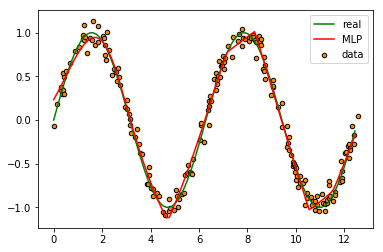

In [8]:
X_ticks = scaler.transform(X_ticks)
X_ticks = torch.from_numpy(X_ticks.astype(np.float32)).to(device)
y_pred = model(X_ticks)

if device.type == 'cuda':
    X = X.cpu().numpy()
    y = y.cpu().numpy()
    X_ticks = X_ticks.cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
else:
    X = X.numpy()
    y = y.numpy()
    X_ticks = X_ticks.mumpy()
    y_pred = y_pred.detach().numpy()

X = scaler.inverse_transform(X)
X_ticks = scaler.inverse_transform(X_ticks)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X.ravel(), y, s=20, c='darkorange', edgecolors='k', label='data')
ax.plot(X_ticks.ravel(), y_real, c='g', label='real')
ax.plot(X_ticks.ravel(), y_pred.flatten(), c='r', label='MLP')
ax.legend()

# Linear SVM

## Linear SVM Loss with soft margin
$$
\min_{w,b}{\frac{1}{2}\|\omega\|^2 + C \cdot \sum_{i=1}^{m}{\max (0,1-y_i(\omega^Tx_i+b))}}
$$

## Other Surrogate Loss
### Hinge Loss
$$
\mathrm{HingeLoss} (z) = \max (0, 1-z)
$$
### Exponential Loss
$$
\mathrm{ExpLoss} (z) = e^{-z}
$$
### Logistic Loss
$$
\mathrm{LogLoss}(z) = \log (1+e^{-z})
$$

## nn.MultiMarginLoss
$$
\mathrm{Loss}(x, y) = \frac{\sum_{i \neq y}{\max (0, (margin-x[y]+x[i]))^p}}{x.size(0)}
$$  

**Note:** The objective is improving the difference between $x[y]$ and $x[i]$, i.e., improving $x[y]-x[i]$, which is equal to reducing $x[i]-x[y]$.  

In [9]:
class LinearSVM(nn.Module):
    def __init__(self, x_dim, n_types):
        super(LinearSVM, self).__init__()
        self.fc = nn.Linear(x_dim, n_types)
        
    def forward(self, x):
        return self.fc(x)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

svm = LinearSVM(2, 2).to(device)

In [11]:
N = 1000
x = np.random.randn(N, 2).astype(np.float32)
y = np.zeros(N, dtype=np.int64)
x[N//2:] += 1
y[N//2:] = 1
x = torch.from_numpy(x).to(device)
y = torch.from_numpy(y).to(device)

svm(x)

tensor([[-0.3727,  0.7053],
        [ 0.3593,  0.1251],
        [-0.2704,  0.9031],
        ...,
        [-0.8340,  1.2515],
        [-1.2775,  1.6106],
        [ 0.0164,  0.3333]], device='cuda:0', grad_fn=<AddmmBackward>)

In [12]:
loss_func = nn.MultiMarginLoss()
optimizer = optim.LBFGS(svm.parameters())

def closure():
    optimizer.zero_grad()
    # MUST put the predicted varibale at the first argument
    loss = loss_func(svm(x), y)
    loss.backward()
    return loss

# Performs a single optimization step
optimizer.step(closure=closure)

list(svm.parameters())

[Parameter containing:
 tensor([[-0.3741, -0.4873],
         [ 0.3933,  0.3995]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.6740, -0.2035], device='cuda:0', requires_grad=True)]

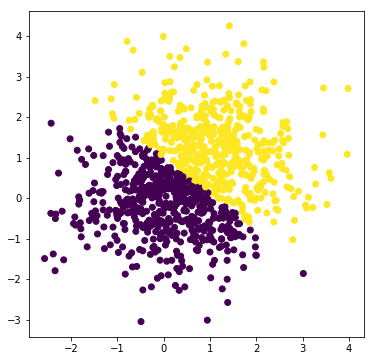

In [13]:
if device.type == 'cuda':
    y_pred = np.argmax(svm(x).detach().cpu().numpy(), axis=1)
    x = x.cpu().numpy()
else:
    y_pred = np.argmax(svm(x).detach().numpy(), axis=1)
    x = x.numpy()


plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0], x[:, 1], c=y_pred)